## EDA and Data Preprocessing

[See separate notebook for EDA](https://github.com/melodygr/grocery_recommendation/blob/main/Capstone_Project.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

## Clustering

In [3]:
# Now I want to experiment with clustering the 'similar' users together
# But what data do I need for each user?  Some kind of summary statistics?
# I guess I need each product to be a column, with the number of times it was ordered?
# Product level is too granular so I am going to try aisle

In [4]:
merged_orders = pickle.load(open("Pickle/merged_orders.p", "rb"))

In [5]:
# What don't I need for my user dataframe?
# Since product level is too granular, I will capture the aisle
user_info = merged_orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 
                           'days_since_prior_order', 'aisle']]

### Get dummy variables for each aisle

In [6]:
user_data = pd.get_dummies(user_info, prefix=None, columns=['aisle'])

In [7]:
user_data.head()
# Group By User_id
# I need max of order_number
# Mode of order_dow, median of order_hour_of_day, mean of days_since
# Sum of each aisle

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,7,17,0,10,28.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7,17,0,10,28.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,2,0,10,9.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,23,2,0,10,9.0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,23,2,0,10,9.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
user_data['aisle_soft drinks'].value_counts()

aisle_soft drinks
False    6738
True      125
Name: count, dtype: int64

### Group By each User Id

In [9]:
# Splitting the data in thirds to use groupby then will rejoin them
user_data1 = user_data[user_data['user_id'] <= 65000]
user_data2 = user_data[(user_data['user_id'] <= 135000) & (user_data['user_id'] > 65000)]
user_data3 = user_data[user_data['user_id'] > 135000]

In [10]:
grouped_user1 = user_data1.groupby('user_id').sum()

In [11]:
grouped_user2 = user_data2.groupby('user_id').sum()

In [12]:
grouped_user3 = user_data3.groupby('user_id').sum()

In [13]:
# Go back to user_data and drop the aisle info before I group the other variables in different ways
user_data1_noaisles = user_data1.iloc[:,:5]
user_data2_noaisles = user_data2.iloc[:,:5]
user_data3_noaisles = user_data3.iloc[:,:5]

In [14]:
# Cool.  Found a way to group each varaiable differently.
group1 = user_data1_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group2 = user_data2_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
group3 = user_data3_noaisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0], 
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})

In [15]:
# get number of orders for each user and add to grouped_user dfs
grouped_user1['num_orders'] = group1.order_number
grouped_user2['num_orders'] = group2.order_number
grouped_user3['num_orders'] = group3.order_number

In [16]:
grouped_user1['mean_days_since'] = group1.days_since_prior_order
grouped_user2['mean_days_since'] = group2.days_since_prior_order
grouped_user3['mean_days_since'] = group3.days_since_prior_order

In [17]:
grouped_user1['mode_order_dow'] = group1.order_dow
grouped_user2['mode_order_dow'] = group2.order_dow
grouped_user3['mode_order_dow'] = group3.order_dow

In [18]:
grouped_user1['median_order_hour'] = group1.order_hour_of_day
grouped_user2['median_order_hour'] = group2.order_hour_of_day
grouped_user3['median_order_hour'] = group3.order_hour_of_day

In [19]:
grouped_user1.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user2.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user3.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)

In [20]:
grouped_users = pd.concat([grouped_user1, grouped_user2, grouped_user3], axis=0)

In [21]:
grouped_users.head()

,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,...,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,num_orders,mean_days_since,mode_order_dow,median_order_hour
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17,28.0,0,10.0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,2,9.0,0,10.0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,63,1.0,3,10.0
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,1.0,1,18.0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,7.0,1,19.0


In [22]:
# This function came from a Medium article by Adam Ross Nelson to rearrange columns in a df
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

In [23]:
grouped_users = movecol(grouped_users, 
             cols_to_move=['num_orders', 'mode_order_dow', 'median_order_hour', 'mean_days_since'], 
             ref_col='aisle_air fresheners candles',
             place='Before')
grouped_users.head()

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,17,0,10.0,28.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,2,0,10.0,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
27,63,3,10.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,10,1,18.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,3,1,19.0,7.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pickle.dump(grouped_users, open("Pickle/grouped_users.p", "wb"))
grouped_users = pickle.load(open("Pickle/grouped_users.p", "rb"))

### Run KMeans clustering

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users) 
scaled_users.shape

(3373, 135)

In [33]:
from sklearn.preprocessing import StandardScaler

# Assuming df is your original DataFrame
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users)

# Convert back to DataFrame to keep column names
scaled_users_df = pd.DataFrame(scaled_users, columns=grouped_users.columns)

missing_columns = scaled_users_df.columns[grouped_users.isna().any()].tolist()
print(missing_columns) 

[]


In [34]:
grouped_users["mean_days_since"] = grouped_users["mean_days_since"].fillna(grouped_users["mean_days_since"].mean())

In [35]:
 
scaled_users  
import numpy as np
np.isnan(scaled_users).sum()

0

In [37]:
from sklearn.cluster import KMeans
random_state = 12

'''The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters,
by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape 
(n_samples, n_clusters).'''

# Is having 20 separate market segments helpful?  Can I figure out what make them different and target that?  

k_means_13 = KMeans(n_clusters=13, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_14 = KMeans(n_clusters=14, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_15 = KMeans(n_clusters=15, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_16 = KMeans(n_clusters=16, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_17 = KMeans(n_clusters=17, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_18 = KMeans(n_clusters=18, random_state=random_state, algorithm='elkan').fit(scaled_users)
k_means_20 = KMeans(n_clusters=20, random_state=random_state, algorithm='elkan').fit(scaled_users)


In [38]:
 pickle.dump(k_means_20, open("Pickle/k_means_20.p", "wb"))

In [39]:
k_means_20 = pickle.load(open("Pickle/k_means_20.p", "rb"))

In [40]:
k_list = [ k_means_13, 
          k_means_14, k_means_15, k_means_16, k_means_17, k_means_18, k_means_20]

In [163]:
from sklearn.metrics import calinski_harabasz_score

CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels)) 

ValueError: x and y must have same first dimension, but have shapes (11,) and (7,)

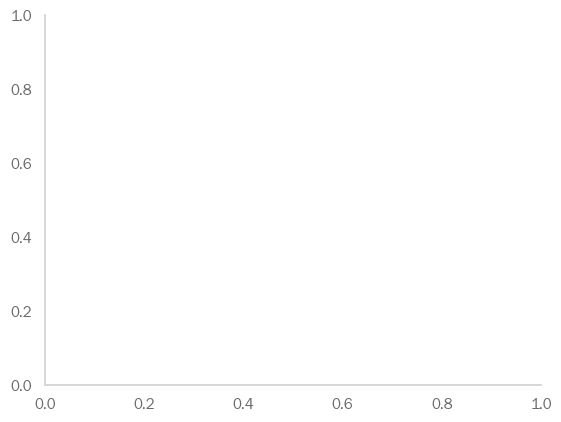

In [164]:
# Need to decide if I keep going with more clusters
# Previous k_means_20 on unscaled data had CH around 16000, now scaled it is at 8000

plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.savefig('Images/ch_scaled_scores.png');

In [44]:
# Looking at Within Cluster Sum of Squares

wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

ValueError: x and y must have same first dimension, but have shapes (11,) and (7,)

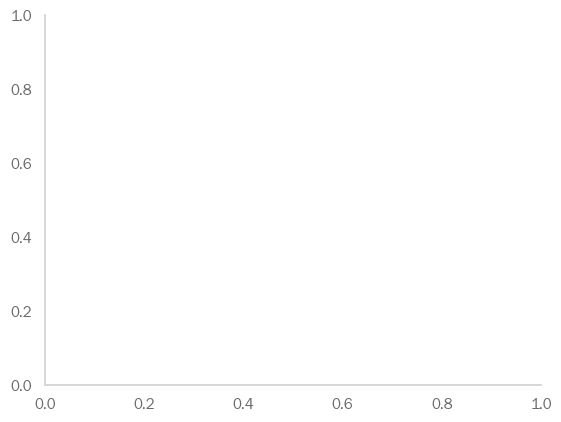

In [45]:
plt.plot([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], wcss_score)
plt.xticks([10,11,12,13,14,15,16,17,18,19,20])
plt.title('Within Cluster Sum of Squares Scores for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.savefig('Images/wcss_scores.png');

In [46]:
# Silhouette score 1 is good, -1 is bad, near 0 means overlapping custers

from sklearn import metrics
metrics.silhouette_score(grouped_users, k_means_20.labels_, sample_size = 30000, random_state = random_state)

-0.4419676061911229

In [47]:
metrics.silhouette_score(grouped_users, k_means_14.labels_, sample_size = 30000, random_state = random_state)

-0.25920846025691974

In [48]:
# OK let's focus on k_means_20 and have a look at our clusters

k_means_20.labels_

array([0, 5, 6, ..., 7, 0, 6])

In [49]:
# Add cluster assignment to the grouped_users dataframe
grouped_users['cluster'] = k_means_20.labels_

In [50]:
pickle.dump(grouped_users, open('Pickle/clustered_users.p', 'wb')) # creating grouped users with cluster info

### Analyze clusters

In [51]:
# There are top 3 big clusters and lots of smaller.  May be hard to determine what the big clusters have in common.
grouped_users.cluster.value_counts()

cluster
0     1924
6      712
5      304
4      105
7      100
3       61
15      47
1       45
11      28
2       14
10       9
18       7
13       3
16       3
8        3
12       2
19       2
17       2
14       1
9        1
Name: count, dtype: int64

In [166]:
# Now take the grouped users and group them by cluster

# For each user, I took the mode of their order_dow.  Now I am taking the median value for the cluster.

cluster_data = grouped_users.groupby('cluster').agg({'num_orders': 'median', 
                                                      'mode_order_dow': lambda x:x.value_counts().index[0], 
                                                     'median_order_hour': 'median', 'mean_days_since': 'mean'})
cluster_data = grouped_users.groupby('cluster').median()

In [167]:
cluster_data # This is the median info for each cluster

# I can see cluster 7 has a lot of baby products

,num_orders,num_products,user_count,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,8.0,1.0,1.0,2.0,14.0,13.833333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.0,3.0,1.0,2.0,14.0,8.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,2.0,1.0,2.0,15.0,9.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,2.0,1.0,2.0,13.0,9.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,2.0,1.0,2.0,12.0,11.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,11.0,2.0,1.0,3.0,13.0,10.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,31.5,2.0,1.0,3.0,13.0,5.845238,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,12.0,3.0,1.0,3.0,14.0,11.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6.0,4.0,1.0,5.0,13.0,17.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
# These are the users that make up cluster 7, and yes they have a lot of baby products

grouped_users[grouped_users['cluster'] == 7]

,num_orders,num_products,user_count,cluster,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
159,3,5,1.0,7,4,9.0,30.000000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
396,19,6,1.0,7,0,13.0,9.166667,0,0,0,...,0,0,0,0,0,0,0,0,0,0
481,19,1,1.0,7,0,14.0,7.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,28,4,1.0,7,0,12.0,22.750000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
762,30,3,1.0,7,2,18.0,7.333333,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,9,8,1.0,7,5,9.0,13.375000,0,0,0,...,0,0,0,0,0,0,0,2,0,0
20085,5,4,1.0,7,4,15.0,4.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20454,26,3,1.0,7,1,16.0,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
# These are all of cluster 7's values that aren't zero... still 62 of them

cluster_data.iloc[7,(cluster_data.loc[7].values > 0)]

num_orders              12.0
num_products             3.0
user_count               1.0
mode_order_dow           3.0
median_order_hour       14.0
mean_days_since         11.0
aisle_frozen produce     1.0
Name: 7, dtype: float64

### Use TSNE to convert cluster data to 3D

In [170]:
# Convert to three dimensional for graphing
from sklearn.manifold import TSNE

# Adjust perplexity to a value less than the number of samples in your dataset
cluster_embedded = TSNE(n_components=3, perplexity=10).fit_transform(cluster_data)

In [171]:
# Create dataframe to plot
cluster_embedded_df = pd.DataFrame(cluster_embedded, index = cluster_data.index, columns = ['1','2','3'])
cluster_embedded_df.reset_index(inplace=True)
cluster_embedded_df

,cluster,1,2,3
0,0,-201.477570,-46.383827,-51.198242
1,1,140.748413,54.311916,-62.807190
2,2,97.698608,-126.976158,-98.490761
3,3,63.816963,96.845039,57.773258
4,4,-47.943844,104.117798,14.339929
5,5,28.515022,-14.361185,40.971249
6,6,101.777008,14.011542,-186.504288
7,7,-92.835678,-87.144066,-144.346405
8,8,204.371368,121.541374,50.983631
9,9,16.714643,-180.899979,7.038330


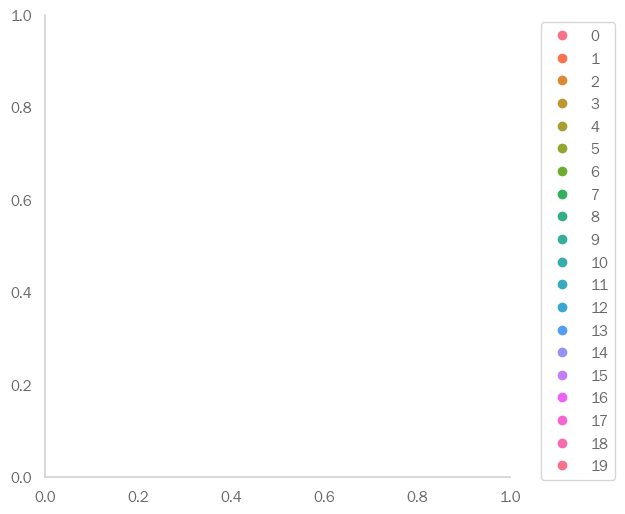

In [172]:
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(cluster_embedded_df['1'], cluster_embedded_df['2'], cluster_embedded_df['3'], 
                s=40, c=cluster_embedded_df['cluster'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(num=20), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("Images/scatter_hue.png", bbox_inches='tight')

In [173]:
# This shows clusters 5, 11, 12, 14, and 17 as being very separate from the rest

import plotly.express as px

fig = px.scatter_3d(cluster_embedded_df, x='1', y='2', z='3', color='cluster')
fig.show() 

In [174]:
# Can I plot all of the users with their cluster color?
# This took about 2 hours and 20 minutes to run.

user_embedded = TSNE(n_components=3).fit_transform(grouped_users.drop(columns='cluster'))

In [175]:
pickle.dump(user_embedded, open("Pickle/user_embedded.p", "wb"))

In [176]:
user_embedded = pickle.load(open("Pickle/user_embedded.p", "rb"))

In [177]:
user_embedded

array([[  0.3040039 ,   9.690479  ,   3.1696064 ],
       [ -8.98401   , -12.313886  ,   2.1930332 ],
       [ 23.600279  ,   5.2160764 ,   2.6689672 ],
       ...,
       [  7.509661  ,  -3.57656   ,   5.714711  ],
       [ -7.748848  ,  -1.4957668 ,   3.4075704 ],
       [  6.101034  ,   2.9570198 ,   0.56539965]], dtype=float32)

In [178]:
# Create dataframe to plot
user_embedded_df = pd.DataFrame(user_embedded, index = grouped_users.index, columns = ['1','2','3'])
user_embedded_df.reset_index(inplace=True)
user_embedded_df['cluster'] = k_means_20.labels_
user_embedded_df.head()

,user_id,1,2,3,cluster
0,7,0.304004,9.690479,3.169606,0
1,23,-8.984010,-12.313886,2.193033,5
2,27,23.600279,5.216076,2.668967,6
3,36,0.521567,-12.961699,-3.204311,1
4,42,-5.608203,-10.031871,-6.437064,0


In [179]:
# just a sample of 200 users, all of them are just a big blob
fig = px.scatter_3d(user_embedded_df.sample(200), x='1', y='2', z='3', color='cluster')
fig.show()

### Cluster Breakdown by Aisle

In [180]:
# Create a way to compare clusters.  Find if they have max or min values for any features.

cluster_metrics = {}
for cluster in cluster_data.index:
    cluster_list = [grouped_users.cluster.value_counts()[cluster]]
    for col in cluster_data.columns:
        if (cluster_data.loc[:,col].max() > 0) & (cluster_data.loc[:,col].idxmax() == cluster):
            cluster_list.append(('max ' + col, cluster_data.loc[cluster,col]))
        if (cluster_data.loc[:,col].min() > 0) & (cluster_data.loc[:,col].idxmin() == cluster):
                cluster_list.append(('min ' + col, cluster_data.loc[cluster,col]))
    cluster_metrics[cluster] = cluster_list

In [181]:
# Clusters 5, 11, 12, 14, and 17 looked very separate from the rest on the graph.

print(cluster_metrics[5]) # Lots of personal care / pharmacy type products
print(cluster_metrics[11]) # Soap and skin care
print(cluster_metrics[12]) # Very large cluster, with fewest number of orders and highest days between orders
print(cluster_metrics[14]) # Tons of veggies, herb, and spices
print(cluster_metrics[17]) # Bulk dried fruits and veggies

[304, ('max aisle_soy lactosefree', 1.0)]
[28, ('max aisle_bulk dried fruits vegetables', 1.0)]
[2, ('max aisle_chips pretzels', 0.5), ('max aisle_ice cream toppings', 1.0), ('max aisle_laundry', 0.5), ('max aisle_water seltzer sparkling water', 0.5)]
[1, ('max num_orders', 41.0), ('max num_products', 11.0), ('max mode_order_dow', 6.0), ('max aisle_dish detergents', 2.0), ('max aisle_latino foods', 1.0), ('max aisle_packaged cheese', 1.0), ('max aisle_paper goods', 3.0), ('max aisle_refrigerated pudding desserts', 4.0)]
[2, ('max aisle_beauty', 1.0), ('max aisle_refrigerated', 0.5), ('max aisle_soap', 1.0)]


In [182]:
#Other interesting clusters

print(cluster_metrics[7]) # Baby products
print(cluster_metrics[8]) # Lots of orders, shortest days between, big buyers
print(cluster_metrics[9]) # Alcohol purchasers
print(cluster_metrics[13]) # Household, laundry, cleaning products
print(cluster_metrics[15]) # Chocolate, gum and soft drinks, least veggies
print(cluster_metrics[16]) # Vegan and tofu

[100, ('max aisle_frozen produce', 1.0)]
[3, ('max aisle_spirits', 1.0)]
[1, ('min num_orders', 5.0), ('max mean_days_since', 30.0), ('max aisle_fresh vegetables', 1.0), ('max aisle_lunch meat', 1.0), ('max aisle_nuts seeds dried fruit', 1.0), ('max aisle_seafood counter', 1.0)]
[3, ('min median_order_hour', 8.0), ('max aisle_first aid', 1.0)]
[47, ('max aisle_oils vinegars', 1.0)]
[3, ('max aisle_frozen meat seafood', 1.0)]


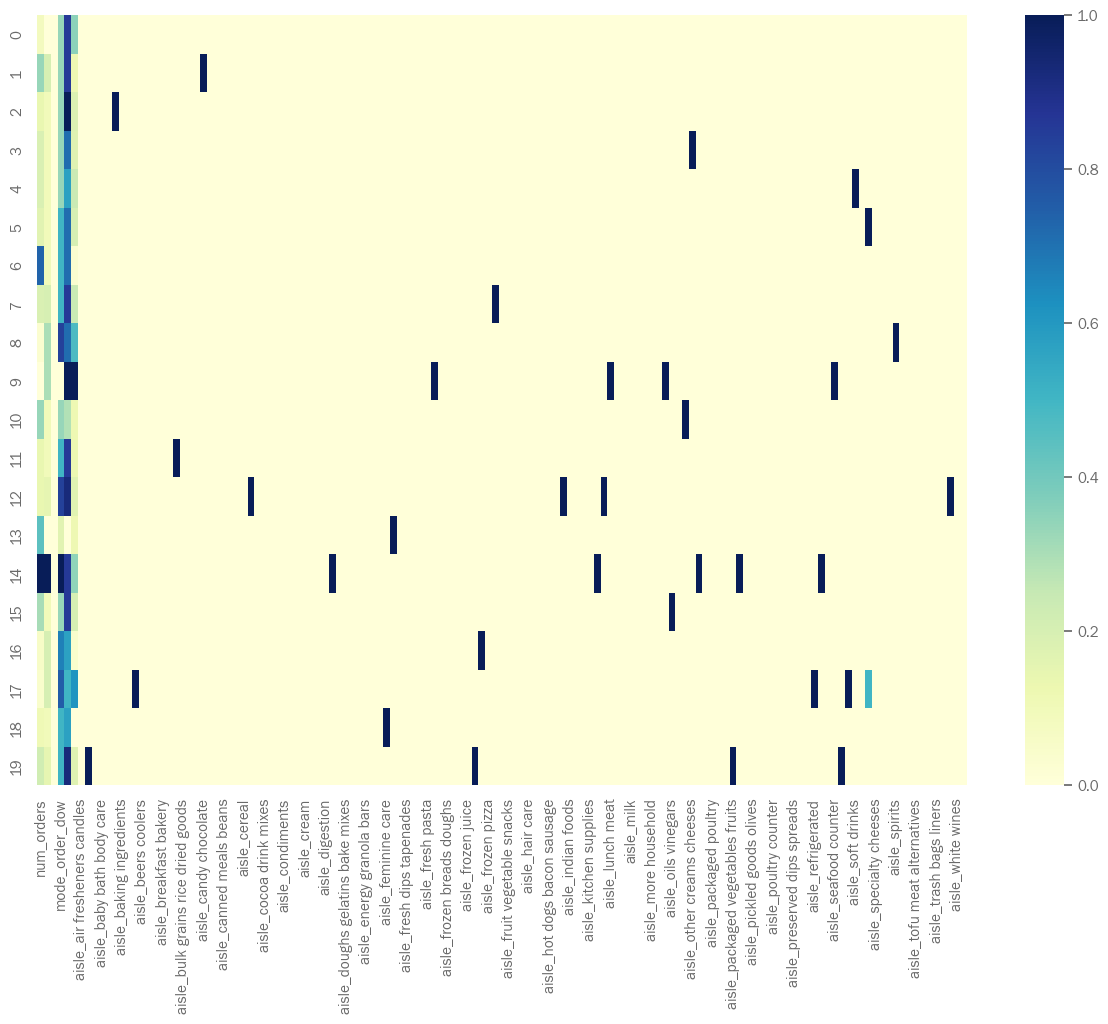

In [183]:
# Make a heatmap of clusters and aisles
# Scale the data first to make it more meaningful
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
graph_data = scaler.fit_transform(cluster_data)
graph_df=pd.DataFrame(graph_data, columns = cluster_data.columns)
fig = plt.figure(figsize=(15,10))
heat_map = sns.heatmap(graph_df, cmap="YlGnBu")
plt.savefig('Images/cluster_heatmap.png')

In [184]:
# Can I write a function to predict what cluster someone will belong in?
# They would have to give me a shopping list... no even then some clusters may be based on order frequency rather than item.
# Or rather, if they give me an item, can I ouput "Others who bought this item also bought..."
# That we will get from the recommendation system below I think

### Cluster Buying Power

In [185]:
# Add up all of the products for each person

grouped_users['num_products'] = grouped_users[grouped_users.columns[4:-1]].sum(axis=1)

In [186]:
# This will be used to count how many users are in each cluster when I do the groupby
grouped_users['user_count'] = list(np.ones(len(grouped_users)))

In [187]:
grouped_users = movecol(grouped_users, 
                        cols_to_move=['num_products', 'user_count', 'cluster'], 
                        ref_col='mode_order_dow', 
                        place='Before')
grouped_users

,num_orders,num_products,user_count,cluster,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,17,40.0,1.0,0,0,10.0,28.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,2,21.0,1.0,5,0,10.0,9.0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
27,63,15.0,1.0,6,3,10.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,10,21.0,1.0,1,1,18.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,3,28.0,1.0,0,1,19.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20571,24,29.0,1.0,0,0,13.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20587,7,51.0,1.0,0,0,20.0,30.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20591,22,26.0,1.0,7,6,7.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
# Group by cluster, adding up the number of products purchased
grouped_clusters = grouped_users.groupby('cluster').sum()
grouped_clusters

,num_orders,num_products,user_count,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,18619,65702.814780,1924.0,4987,26076.0,31428.814780,4,34,1,0,...,44,37,12,17,0,1,8,114,21,0
1,997,1402.215865,45.0,117,632.5,508.715865,0,3,0,0,...,2,3,1,0,0,0,0,5,2,4
2,312,444.283131,14.0,33,193.0,176.283131,0,0,0,0,...,3,1,0,0,0,0,2,1,0,0
3,1221,1878.698996,61.0,151,821.5,751.198996,0,1,0,0,...,1,1,1,0,0,0,0,0,0,7
4,1815,3326.643635,105.0,282,1326.0,1497.643635,0,0,0,0,...,3,4,0,0,0,0,0,4,0,3
5,5033,9526.668284,304.0,835,4030.0,4034.668284,0,4,0,0,...,10,6,3,2,0,0,2,9,2,172
6,25413,18009.436482,712.0,2296,9387.5,4648.936482,0,12,0,3,...,28,17,1,2,1,3,8,48,0,13
7,2071,3289.732119,100.0,267,1387.0,1359.732119,0,1,0,0,...,1,2,3,1,0,0,2,12,1,6
8,65,108.000000,3.0,10,37.0,49.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [189]:
# This doesn't take into account the relative prices of the items purchased
# But we can now see the portion of products purchased by each cluster
cluster_power = grouped_clusters.iloc[:,0:3]

In [190]:
cluster_power

,num_orders,num_products,user_count
cluster,,,
0,18619,65702.814780,1924.0
1,997,1402.215865,45.0
2,312,444.283131,14.0
3,1221,1878.698996,61.0
4,1815,3326.643635,105.0
5,5033,9526.668284,304.0
6,25413,18009.436482,712.0
7,2071,3289.732119,100.0
8,65,108.000000,3.0


In [191]:
# Calculate ordering statistics per cluster
cluster_power['portion_of_orders'] = cluster_power['num_orders'].apply(lambda x: 
                                                                             x/(cluster_power['num_orders'].sum()))
cluster_power['portion_of_products'] = cluster_power['num_products'].apply(lambda x: 
                                                                                 x/(cluster_power['num_products'].sum()))
cluster_power['portion_of_users'] = cluster_power['user_count'].apply(lambda x: 
                                                                             x/(cluster_power['user_count'].sum()))
cluster_power['orders_per_user'] = cluster_power['num_orders']/cluster_power['user_count']
cluster_power['products_per_user'] = cluster_power['num_products']/cluster_power['user_count']

In [192]:
cluster_power.sort_values('products_per_user', ascending=False)

,num_orders,num_products,user_count,portion_of_orders,portion_of_products,portion_of_users,orders_per_user,products_per_user
cluster,,,,,,,,
9,5,49.000000,1.0,0.000087,0.000458,0.000296,5.000000,49.000000
14,41,44.636364,1.0,0.000711,0.000417,0.000296,41.000000,44.636364
17,13,78.666667,2.0,0.000225,0.000735,0.000593,6.500000,39.333333
8,65,108.000000,3.0,0.001127,0.001010,0.000889,21.666667,36.000000
0,18619,65702.814780,1924.0,0.322753,0.614281,0.570412,9.677235,34.149072
7,2071,3289.732119,100.0,0.035900,0.030757,0.029647,20.710000,32.897321
15,967,1543.150389,47.0,0.016763,0.014428,0.013934,20.574468,32.832987
2,312,444.283131,14.0,0.005408,0.004154,0.004151,22.285714,31.734509
4,1815,3326.643635,105.0,0.031462,0.031102,0.031130,17.285714,31.682320


### Clustering Conclusions

Sorting these statistics different ways shows interesting results depending on what you are looking for.  We can see
that cluster 8 orders a very large number of products per user, but overall cluster 8 represents a small portion of all
of the users.  Cluster 12 represents over 50% of all of the users, but only 25% of the orders and only 17% of the products.
Cluster 1 is very proportional with about 23% of the users, orders, and products.  Cluster 4 is the third largest cluster
with 7% of the users, but they make up about 17% of the orders and products.

Overall, the clustering did a good job of categorizing our users based on their purchases.  I think this information could be very useful to a business looking to personalize marketing efforts to their users.

## NLP Metadata search engine

In [193]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [194]:
products_desc = pickle.load(open("Pickle/products_desc.p", "rb"))

### Create the metadata and fit to a vectorizer

In [195]:
products_desc['metadata'] = products_desc.apply(lambda x : x['aisle']+' '+x['department']+' '+x['product_name'], axis = 1)

In [196]:
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department,metadata
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,cookies cakes snacks Chocolate Sandwich Cookies
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,spices seasonings pantry All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,tea beverages Robust Golden Unsweetened Oolong...
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,frozen meals frozen Smart Ones Classic Favorit...
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,marinades meat preparation pantry Green Chile ...


In [197]:
count_vec = CountVectorizer(stop_words='english')
count_vec_matrix = count_vec.fit_transform(products_desc['metadata'])

In [198]:
count_vec_matrix.shape

(5688, 4139)

In [199]:
# This function takes in any words and vectorizes them, then finds similar vector in the count_vec_matrix

def vectorize_products_based_on_metadata(product_input):

    vec = count_vec.transform(pd.Series(product_input))
    
    simil = cosine_similarity(vec, count_vec_matrix)
    
    simil_scores = pd.DataFrame(simil.reshape(5688,), index = products_desc.index, columns=['score'])
    
    # Don't return scores of zero, only as many positive scores as exist
    non_zero_scores = simil_scores[simil_scores['score'] > 0]
    
    if len(non_zero_scores) == 0:
        print('No similar products found.  Please refine your search terms and try again')
        return
    
    if len(non_zero_scores) < 10:
        item_count = len(non_zero_scores)
    else:
        item_count = 10
    
    similarity_scores = simil_scores.sort_values(['score'], ascending=False)[:item_count]
    
    return (products_desc['product_name'].iloc[similarity_scores.index])

In [200]:
vectorize_products_based_on_metadata('Bubble Bath')

3490    Everyday Shea Lavender Bubble Bath
3865              Calendula Baby Bath Wash
1618                 Lavender Seaweed Bath
1899                          Bath Laponge
2085          Sustainably Soft Bath Tissue
1481      Bath Tissue 1000 Sheets Per Roll
3520        Cool Watermelon 2-In-1 Shampoo
2684               Calming Everyday Lotion
4310      1000 Sheets Per Roll Bath Tissue
4541                  Diaper Rash Ointment
Name: product_name, dtype: object

In [201]:
vectorize_products_based_on_metadata('Oreo')

2408                    Oreo Mini 20 Count Multipack 20oz
3125                          Oreo Cookie n' Cream Yogurt
795        Chocolate Reese's Peanut Butter Cup Creme Oreo
3259               Chips Ahoy!/Nutter Butter/Oreo Cookies
4056    Oreo Instant Cookies 'n Cream Pudding & Pie Fi...
590     Oreo Cookies and Cream Chocolate Frozen Dairy ...
Name: product_name, dtype: object

In [202]:
vectorize_products_based_on_metadata('Oreos')

# Interesting that only results with "oreos" show up and not 'oreo'

No similar products found.  Please refine your search terms and try again


In [203]:
vectorize_products_based_on_metadata('Oreos Cookies')

# Even adding 'cookies' doesn't get me oreo

1623             Chocolate Cookies
0       Chocolate Sandwich Cookies
2962      Lemon Shortbread Cookies
101          Danish Butter Cookies
5518          Cinnamon Bun Cookies
4690        Creme Sandwich Cookies
575          Vanilla Sugar Cookies
5388         Circus Animal Cookies
2516        Vanilla Animal Cookies
3416       Chocolate Creme Cookies
Name: product_name, dtype: object

In [204]:
vectorize_products_based_on_metadata('Premium Almonds')

5597                              Organic Tamari Almonds
4149                                       Premium Genoa
1942                                Mango Premium Nectar
3432    Sensitivity Ultra Thin Premium Lubricant Condoms
1414                                   Premium Soy Sauce
3037                               Premium Malt Beverage
2810                         Ground Almonds For Passover
642                          Kidney Beans, Dark, Premium
4107                                    Almonds, Marcona
4610                Fair Trade Blackberry Premium Spread
Name: product_name, dtype: object

In [205]:
# I'd rather put more weight on the noun and less on the adjective
# Can look into word embeddings for this

vectorize_products_based_on_metadata('Red Potatoes')

3492                                    Baby Red Potatoes
5651                                 Organic Red Potatoes
4739                                            Decoy Red
2902                                            Sweet Red
1698                                     Jumilla Red Wine
566                                       Malbec Red Wine
3496                            Grape Wine, Delicious Red
478               Most Wanted Cabernet Sauvignon Red Wine
3827              Midnight California Dark Red Wine Blend
318     Steamfresh Chef's Favorites Lightly Sauced Roa...
Name: product_name, dtype: object

In [206]:
vectorize_products_based_on_metadata('randomword') # Showing edge case of no matches

No similar products found.  Please refine your search terms and try again


### Stem the product metadata and refit

These are mostly proper names of products so I don't think I want to lemmatize as that may change the product name too much.

In [207]:
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english") 

In [208]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Echlon
[nltk_data]     Defence\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [209]:
stem_list=[]
for i in range(len(products_desc['metadata'])):
    word_list = nltk.word_tokenize(products_desc['metadata'][i])
    stem_set = list(set([stemmer.stem(word) for word in word_list]))
    stem_list.append(' '.join(stem_set))

In [210]:
from collections import defaultdict
word_count=defaultdict(int)
for idx, product in enumerate(stem_list):
    for word in product.split():
        word_count[word] +=1

In [211]:
# word_count

In [212]:
# trying to figure out how to make this smaller for FLASK
# Can I remove words only used once?

word_ones=[]
for word, count in word_count.items():
    if count == 1:
        word_ones.append(word)

In [213]:
len(word_ones)

1827

In [214]:
new_stem_list=[]
for i in range(len(products_desc['metadata'])):
    word_list = nltk.word_tokenize(products_desc['metadata'][i])
    stem_set = list(set([stemmer.stem(word) for word in word_list if stemmer.stem(word) not in word_ones]))
    new_stem_list.append(' '.join(stem_set))        

In [215]:
products_desc['stemmed'] = stem_list
products_desc['new_stemmed'] = new_stem_list

In [216]:
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department,metadata,stemmed,new_stemmed
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,cookies cakes snacks Chocolate Sandwich Cookies,sandwich cooki snack cake chocol,sandwich cooki snack cake chocol
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,spices seasonings pantry All-Seasons Salt,season spice pantri all-season salt,salt season pantri spice
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,tea beverages Robust Golden Unsweetened Oolong...,robust golden tea unsweeten oolong beverag,golden oolong tea unsweeten beverag
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,frozen meals frozen Smart Ones Classic Favorit...,vodka sauc mini rigatoni meal favorit frozen c...,vodka sauc mini rigatoni meal favorit frozen c...
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,marinades meat preparation pantry Green Chile ...,anytim sauc marinad prepar green meat pantri c...,sauc marinad prepar green meat pantri chile


In [217]:
products_desc.to_pickle("Pickle/products_desc_stemmed.p")

In [218]:
products_desc_stemmed = pickle.load(open("Pickle/products_desc_stemmed.p", "rb"))

In [219]:
# Passing pieces of dataframe in FLASK to be put back together there
pickle.dump(products_desc_stemmed.columns.values,open('Pickle/prod_columns.p','wb'))
pickle.dump(products_desc_stemmed.index.values, open('Pickle/prod_index.p', 'wb'))
pickle.dump(products_desc_stemmed.product_name.values, open('Pickle/prod_name.p', 'wb'))
pickle.dump(products_desc_stemmed.aisle.values, open('Pickle/prod_aisle.p', 'wb'))
pickle.dump(products_desc_stemmed.product_id.values, open('Pickle/prod_id.p', 'wb'))

In [220]:
products_desc_stemmed.product_name.values

array(['Chocolate Sandwich Cookies', 'All-Seasons Salt',
       'Robust Golden Unsweetened Oolong Tea', ...,
       'Organic Vegi-D Zing Salad Salt Free',
       'Multi Cat Unscented Scoopable Cat Litter',
       'Organic Tofu Veggie Burger'], dtype=object)

In [221]:
products_desc_stemmed

,product_id,product_name,aisle_id,department_id,aisle,department,metadata,stemmed,new_stemmed
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,cookies cakes snacks Chocolate Sandwich Cookies,sandwich cooki snack cake chocol,sandwich cooki snack cake chocol
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,spices seasonings pantry All-Seasons Salt,season spice pantri all-season salt,salt season pantri spice
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,tea beverages Robust Golden Unsweetened Oolong...,robust golden tea unsweeten oolong beverag,golden oolong tea unsweeten beverag
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,frozen meals frozen Smart Ones Classic Favorit...,vodka sauc mini rigatoni meal favorit frozen c...,vodka sauc mini rigatoni meal favorit frozen c...
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,marinades meat preparation pantry Green Chile ...,anytim sauc marinad prepar green meat pantri c...,sauc marinad prepar green meat pantri chile
...,...,...,...,...,...,...,...,...,...
5683,5684,Gluten Free Multi Seed Rice Thin Crackers,78,19,crackers,snacks,crackers snacks Gluten Free Multi Seed Rice Th...,multi seed snack free rice thin gluten cracker,multi seed snack free rice thin gluten cracker
5684,5685,Get Clean Cleansing Teas,94,7,tea,beverages,tea beverages Get Clean Cleansing Teas,get clean cleans tea beverag,get clean cleans tea beverag
5685,5686,Organic Vegi-D Zing Salad Salt Free,14,20,tofu meat alternatives,deli,tofu meat alternatives deli Organic Vegi-D Zin...,deli vegi-d zing organ tofu meat free salad sa...,deli organ tofu meat free salad salt altern
5686,5687,Multi Cat Unscented Scoopable Cat Litter,41,8,cat food care,pets,cat food care pets Multi Cat Unscented Scoopab...,food multi cat litter pet unscent scoopabl care,food multi cat litter pet unscent care


In [222]:
np.array(products_desc['stemmed'])[0]

'sandwich cooki snack cake chocol'

In [223]:
# Fitting the vectorizer
stem_count_vec = CountVectorizer(stop_words='english')
stem_count_vec_matrix = stem_count_vec.fit_transform(products_desc['stemmed'])

In [224]:
stem_count_vec_matrix.shape # reduced the size from 10624 to 9086 words

(5688, 3544)

In [225]:
# Fitting the vectorizer with one time words removed
new_stem_count_vec = CountVectorizer(stop_words='english')
new_stem_count_vec_matrix = new_stem_count_vec.fit_transform(products_desc['new_stemmed'])

In [226]:
new_stem_count_vec_matrix.shape

(5688, 1884)

In [227]:
pickle.dump(stem_count_vec, open("Pickle/stem_count_vec.p", "wb"))
pickle.dump(stem_count_vec_matrix, open("Pickle/stem_count_vec_matrix.p", "wb"))
pickle.dump(new_stem_count_vec, open("Pickle/new_stem_count_vec.p", "wb"))
pickle.dump(new_stem_count_vec_matrix, open("Pickle/new_stem_count_vec_matrix.p", "wb"))

In [228]:
# This improved function takes in any words and stems and vectorizes them

def stem_and_vectorize_products_based_on_metadata(product_input):

    word_list = nltk.word_tokenize(product_input)

    input_stemmed = ' '.join([stemmer.stem(word) for word in word_list])

    vec = stem_count_vec.transform(np.array(input_stemmed).reshape(1,)) # changed to array instead of Series for time
    
    simil = cosine_similarity(vec, stem_count_vec_matrix)
    
    simil_scores = pd.DataFrame(simil.reshape(stem_count_vec_matrix.shape[0],), 
                                index = products_desc.index, columns=['score'])
    
    # Don't return scores of zero, only as many positive scores as exist
    non_zero_scores = simil_scores[simil_scores['score'] > 0]
    
    if len(non_zero_scores) == 0:
        print('No similar products found.  Please refine your search terms and try again')
        return
    
    if len(non_zero_scores) < 10:
        item_count = len(non_zero_scores)
    else:
        item_count = 10
    
    similarity_scores = simil_scores.sort_values(['score'], ascending=False)[:item_count]
    
    return (products_desc['product_name'].iloc[similarity_scores.index])

In [229]:
# rather than just printing out I want to store the recs to use in FLASK
recs = stem_and_vectorize_products_based_on_metadata('Oreos') 

In [230]:
recs

3125                          Oreo Cookie n' Cream Yogurt
590     Oreo Cookies and Cream Chocolate Frozen Dairy ...
3259               Chips Ahoy!/Nutter Butter/Oreo Cookies
2408                    Oreo Mini 20 Count Multipack 20oz
795        Chocolate Reese's Peanut Butter Cup Creme Oreo
4056    Oreo Instant Cookies 'n Cream Pudding & Pie Fi...
Name: product_name, dtype: object

In [231]:
# Looking at how to access the data while I am in FLASK
recs.iloc[0]

"Oreo Cookie n' Cream Yogurt"

In [232]:
recs.index[0]

3125

In [233]:
recs2 = stem_and_vectorize_products_based_on_metadata('randomword')

No similar products found.  Please refine your search terms and try again


In [234]:
type(recs2)

NoneType

In [235]:
# Now Oreo and Oreos give me the same vector and output
stem_and_vectorize_products_based_on_metadata('Oreo')

3125                          Oreo Cookie n' Cream Yogurt
590     Oreo Cookies and Cream Chocolate Frozen Dairy ...
3259               Chips Ahoy!/Nutter Butter/Oreo Cookies
2408                    Oreo Mini 20 Count Multipack 20oz
795        Chocolate Reese's Peanut Butter Cup Creme Oreo
4056    Oreo Instant Cookies 'n Cream Pudding & Pie Fi...
Name: product_name, dtype: object

In [236]:
stem_and_vectorize_products_based_on_metadata('Premium Almonds') # these results are better too

5597                              Organic Tamari Almonds
4190                                         Almond Cake
2591                                    Maple Almond Bar
2887                                 Almond Cocoa Spread
5128                                         Almond Bark
3432    Sensitivity Ultra Thin Premium Lubricant Condoms
1440                          Quinoa Cereal Honey Almond
450                        Almond Spread, Dark Chocolate
4636                            Triple Chocolate Almonds
934                                  Premium Apple Juice
Name: product_name, dtype: object

In [237]:
stem_and_vectorize_products_based_on_metadata('Red Potatoes')

5651                                 Organic Red Potatoes
3492                                    Baby Red Potatoes
318     Steamfresh Chef's Favorites Lightly Sauced Roa...
2562    Roasted Garlic & Parmesan Baby Reds Mashed Pot...
572                                             Red Roses
2902                                            Sweet Red
1915                                          Merlot Wine
3148                                        Meritage Wine
3373                                         Sweet Potato
1007                                    Red Rice Crackers
Name: product_name, dtype: object

In [238]:
# Much happier with this output now that we have tokenized, stemmed, and joined the words

### NLP Conclusions

In [239]:
'''The NLP search engine would be a useful tool for online shopping recommendations.  Perhaps generating word embeddings
could even improve the results.'''

'The NLP search engine would be a useful tool for online shopping recommendations.  Perhaps generating word embeddings\ncould even improve the results.'

In [240]:
prod_columns = pickle.load(open('Pickle/prod_columns.p','rb'))
prod_index = pickle.load(open('Pickle/prod_index.p', 'rb'))
prod_name = pickle.load(open('Pickle/prod_name.p', 'rb'))
prod_aisle = pickle.load(open('Pickle/prod_aisle.p', 'rb'))
prod_id = pickle.load(open('Pickle/prod_id.p', 'rb'))

In [241]:
new_df = pd.DataFrame(np.column_stack([prod_name, prod_aisle, prod_id]), index=prod_index, columns=['product_name', 'aisle', 'product_id']) 

